In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import pi

os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# 1. Load and prepare dataset
df = pd.read_csv("Linhac24-25_Sportlogiq.csv")
df = df.sort_values(by=['gameid', 'compiledgametime'])

# ========== 2. Event flags with renamed variables ==========
df['num_passes'] = (df['eventname'] == 'pass').astype(int)
df['num_zone_entries'] = (df['eventname'] == 'controlledentry').astype(int)
df['num_assists'] = (df['eventname'] == 'assist').astype(int)
df['num_blocks'] = (df['eventname'] == 'block').astype(int)
df['num_entries_against'] = (df['eventname'] == 'controlledentryagainst').astype(int)
df['num_dumpouts'] = (df['eventname'] == 'dumpout').astype(int)
df['num_shots'] = df['eventname'].isin(['shot', 'goal']).astype(int)

# ========== 3. Success flags ==========
df['num_successful_passes'] = ((df['eventname'] == 'pass') & (df['outcome'] == 'successful')).astype(int)
df['num_successful_zone_entries'] = ((df['eventname'] == 'controlledentry') & (df['outcome'] == 'successful')).astype(int)
df['num_successful_entries_against'] = ((df['eventname'] == 'controlledentryagainst') & (df['outcome'] == 'successful')).astype(int)

# ========== 4. Carry duration & distance ==========
df['is_carry'] = (df['eventname'] == 'carry').astype(int)
carry_df = df[df['is_carry'] == 1].copy()
carry_df['next_x'] = df['xadjcoord'].shift(-1)
carry_df['next_y'] = df['yadjcoord'].shift(-1)
carry_df['carry_distance'] = np.sqrt((carry_df['next_x'] - carry_df['xadjcoord'])**2 + (carry_df['next_y'] - carry_df['yadjcoord'])**2)
carry_df['carry_duration'] = df['compiledgametime'].shift(-1) - carry_df['compiledgametime']
carry_avg = carry_df.groupby(['teamid', 'gameid'])[['carry_distance', 'carry_duration']].mean().reset_index()
carry_avg.rename(columns={'carry_distance': 'avg_carry_distance', 'carry_duration': 'avg_carry_duration'}, inplace=True)

# ========== 5. Aggregated metrics ==========
agg_cols = [
    'num_passes', 'num_successful_passes', 'num_zone_entries', 'num_successful_zone_entries',
    'num_assists', 'num_blocks', 'num_entries_against', 'num_dumpouts', 'num_shots'
]
agg_dict = {col: 'sum' for col in agg_cols}
agg_dict['xg_allattempts'] = 'mean'
agg_df = df.groupby(['teamid', 'gameid']).agg(agg_dict).reset_index()
agg_df = agg_df.merge(carry_avg, on=['teamid', 'gameid'], how='left')

# ========== 6. Final score + result ==========
last_score = df.sort_values(['gameid', 'compiledgametime']).groupby(['teamid', 'gameid'])['scoredifferential'].last().reset_index()
agg_df = agg_df.drop(columns='scoredifferential', errors='ignore')
agg_df = agg_df.merge(last_score, on=['teamid', 'gameid'], how='left')
agg_df['result'] = agg_df['scoredifferential'].apply(lambda x: 1 if x > 0 else (0 if x < 0 else 0.5))

# ========== 7. Derived success rates ==========
agg_df['pass_success_rate'] = agg_df['num_successful_passes'] / agg_df['num_passes'].replace(0, np.nan)
agg_df['entry_success_rate'] = agg_df['num_successful_zone_entries'] / agg_df['num_zone_entries'].replace(0, np.nan)

entry_against_stats = df.groupby(['teamid', 'gameid'])[['num_successful_entries_against', 'num_entries_against']].sum().reset_index()
entry_against_stats['entry_against_success_rate'] = entry_against_stats['num_successful_entries_against'] / entry_against_stats['num_entries_against'].replace(0, np.nan)
agg_df = agg_df.merge(entry_against_stats[['teamid', 'gameid', 'entry_against_success_rate']], on=['teamid', 'gameid'], how='left')

# ========== 8. Feature list for clustering ==========
features_v2 = [
    'num_passes', 'num_zone_entries', 'num_assists', 'num_blocks',
    'num_entries_against', 'num_dumpouts', 'num_shots', 'xg_allattempts',
    'pass_success_rate', 'entry_success_rate', 'entry_against_success_rate',
    'avg_carry_duration', 'avg_carry_distance'
]
X = StandardScaler().fit_transform(agg_df[features_v2])

# 8. Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
agg_df['cluster'] = kmeans.fit_predict(X)
style_names = {0: 'Puck Control Play', 1: 'Defensive Counterattack', 2: 'High-Pressure Offense'}
agg_df['style'] = agg_df['cluster'].map(style_names)

In [3]:
print(agg_df)

     teamid  gameid  num_passes  num_successful_passes  num_zone_entries  \
0       503   60116         412                    297                36   
1       503   60592         532                    429                45   
2       503   61890         398                    290                43   
3       503   62544         535                    421                54   
4       503   63973         520                    396                55   
..      ...     ...         ...                    ...               ...   
307     885   86775         412                    328                36   
308     885   87004         365                    283                40   
309     885   87018         325                    229                41   
310     885   87190         410                    276                41   
311     885   88030         348                    231                34   

     num_successful_zone_entries  num_assists  num_blocks  \
0                         

In [9]:
from change import possession_change_events

In [10]:
pos_change = possession_change_events(df)

In [11]:
from change import visualize_style_possession_losses

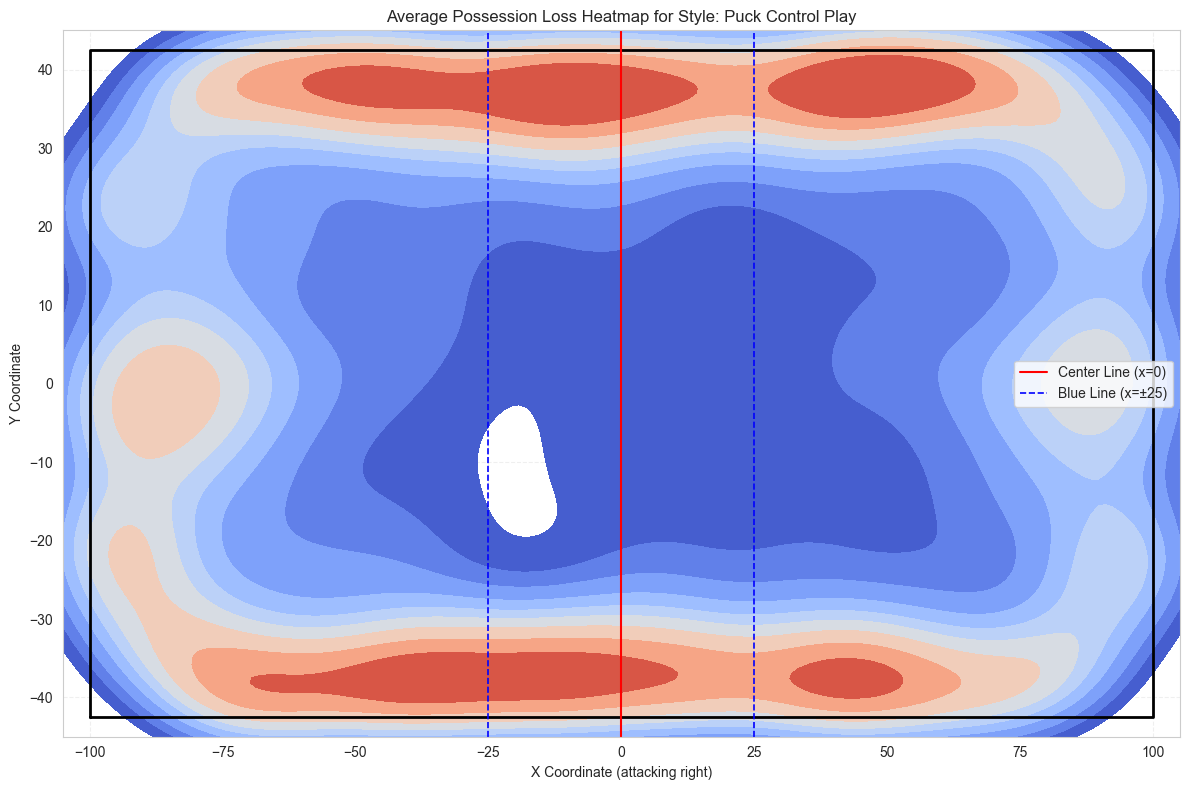

In [12]:
visualize_style_possession_losses('Puck Control Play', agg_df, pos_change)


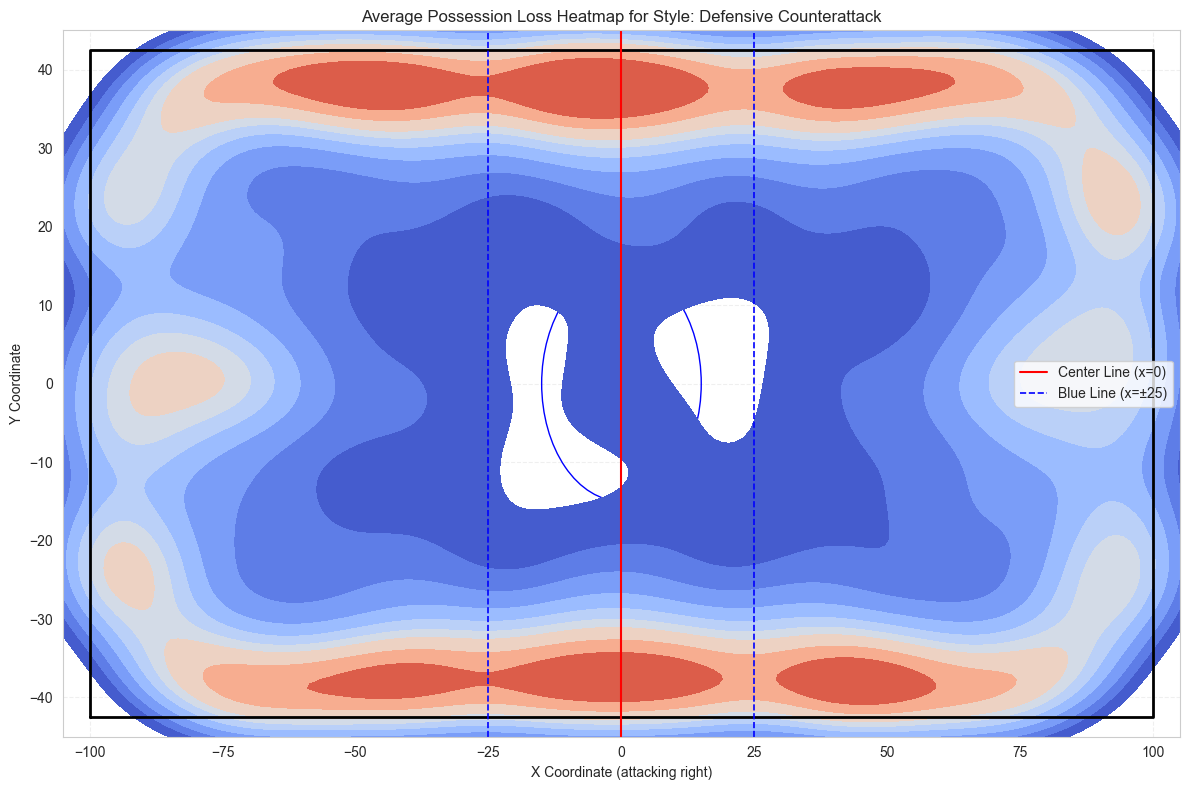

In [7]:
visualize_style_possession_losses('Defensive Counterattack', agg_df, pos_change)

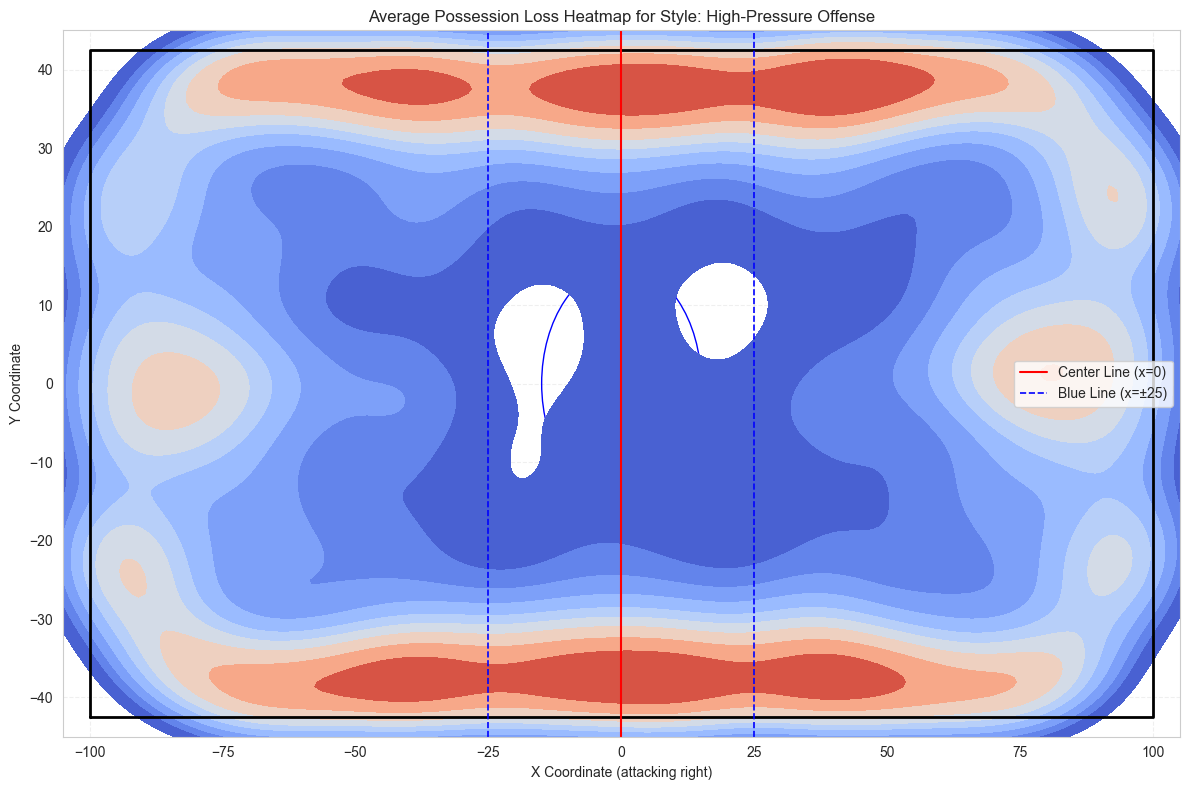

In [8]:
visualize_style_possession_losses('High-Pressure Offense', agg_df, pos_change)